The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


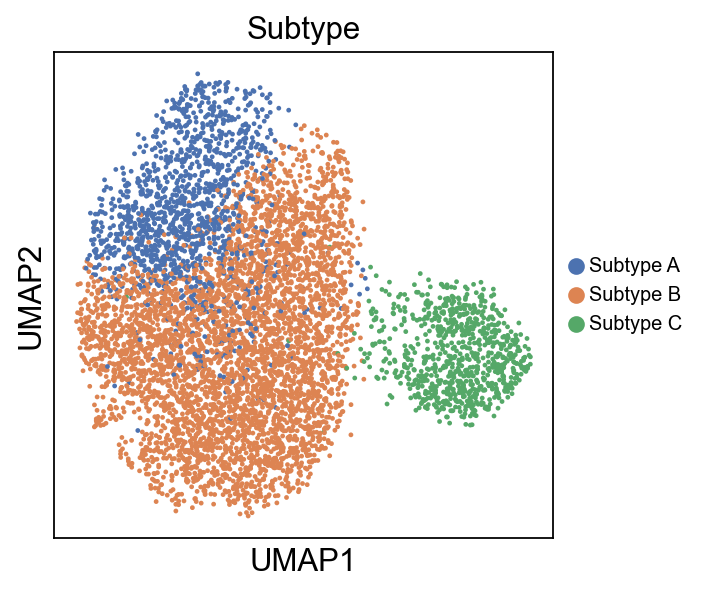

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


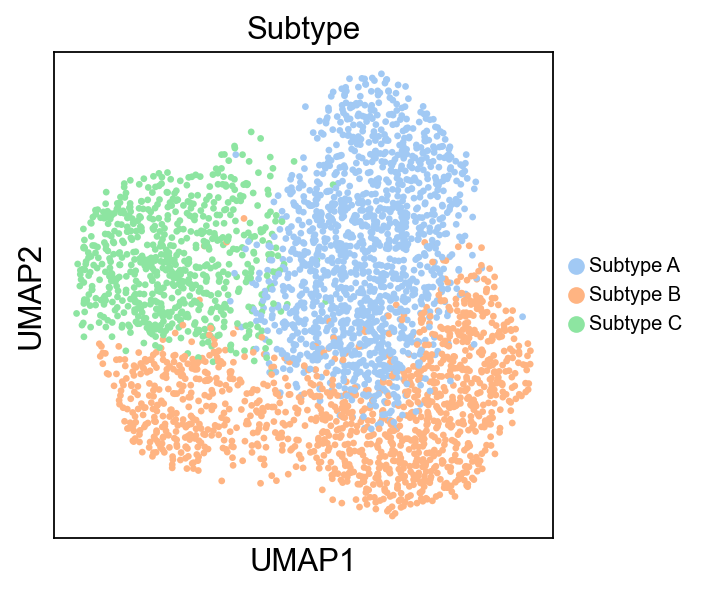

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [34]:
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import fsspec
import scvi
import scvelo as scv
import h5py
import anndata
import pandas as pd
import network
from scvi.model.utils import mde
import numpy as np
import networkx
import desc 
import matplotlib as plt
import umap
import seaborn as sns
import scib
import torch
#import scarches as sca
#from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import pymde
import muon
import anndata
import matplotlib as mpl


%matplotlib inline 
%load_ext rpy2.ipython
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
sc.settings.verbosity = 3 
sc.set_figure_params(figsize=(4, 4))


# Reading in the adata file from the subtype data
adata_152 = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_adata_subtype_PCA.h5ad")


# Plotting the umap based on subtype
sc.pl.umap(adata_152, color=['Subtype'], legend_fontsize=9)


# setting keys
cell_type_key = 'Subtype'


# Reading in the adata file from the subtype data
adata_384 = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_PCA_subtype.h5ad")

                     
sc.pl.umap(adata_384, color=['Subtype'], legend_fontsize=9)

# making a gene list for OS384
OS384_var_names = list(adata_384.var.index.values)


# remove duplicated from list 
OS384_genes = [] 
for i in OS384_var_names: 
    if i not in OS384_genes: 
        OS384_genes.append(i) 
        
        
# making a list of 152 genes
OS152_genes = list(adata_152.var.index.values)


# Python program to illustrate the intersection
# of two lists using set() method
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
 
    
# Identiyfing the common genes within these samples
common_genes = intersection(OS384_genes, OS152_genes)


# Filtering 152 for the common genes
muon.pp.filter_var(adata_152, common_genes)


# Filtering OS384 for the common genes
muon.pp.filter_var(adata_384, common_genes)


# Setting up the anndata object to include continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata_152,
    layer="counts",
    continuous_covariate_keys=["pct_counts_mt", "ccdifference"]
)


# Setting up the anndata object to include continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata_384,
    layer="counts",
    continuous_covariate_keys=["pct_counts_mt", "ccdifference"]
)

# OS152 to OS384

python(78422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
python(78423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 400/400: 100%|███████| 400/400 [04:01<00:00,  1.77it/s, loss=317, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [04:01<00:00,  1.66it/s, loss=317, v_num=1]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


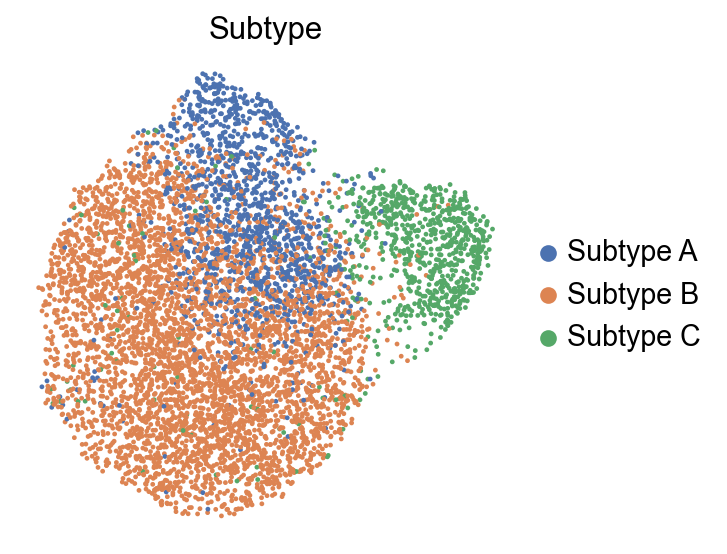

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


INFO     Training for 20 epochs.                                                                                   


python(78516) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
python(78517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 20/20: 100%|███████████| 20/20 [00:23<00:00,  1.11s/it, loss=325, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████| 20/20 [00:23<00:00,  1.15s/it, loss=325, v_num=1]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


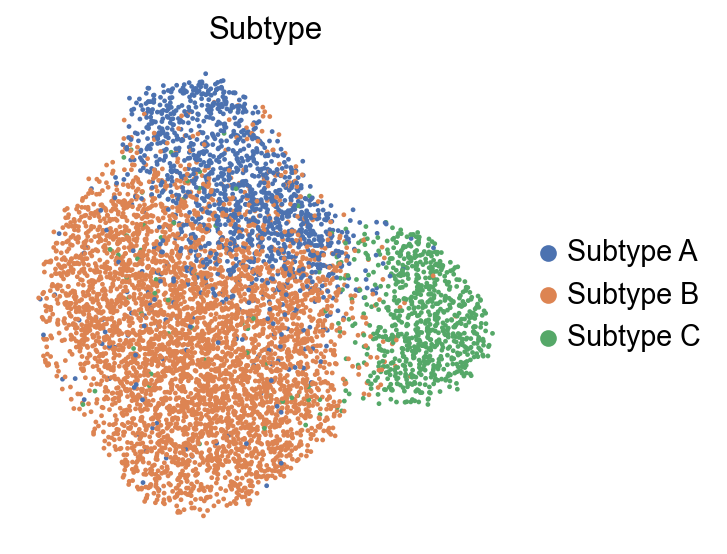

INFO     File OS152_model_scanvi_full_384/model.pt already downloaded                                              
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File OS152_model_scanvi_full_384/model.pt already downloaded                                              
INFO     Training for 100 epochs.                                                                                  


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
python(78539) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
python(78540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 100/100: 100%|███████| 100/100 [00:48<00:00,  1.92it/s, loss=485, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████| 100/100 [00:48<00:00,  2.06it/s, loss=485, v_num=1]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


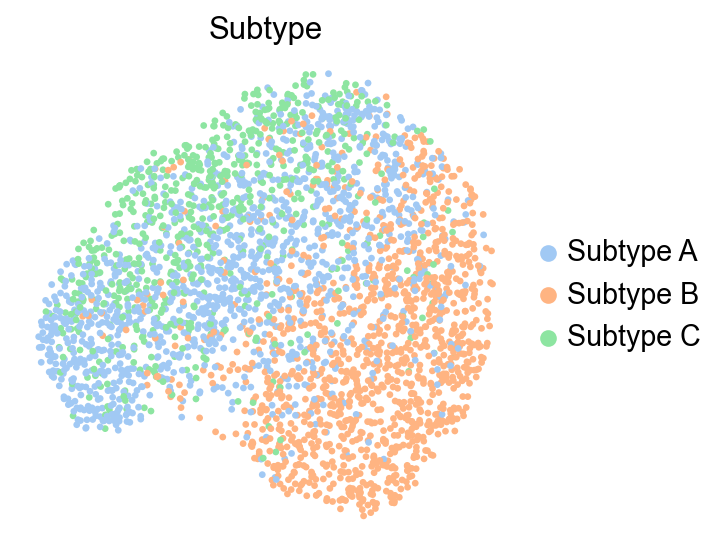

/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_48615/2022833872.py:149: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  _ = plt.colorbar(mpl.cm.ScalarMappable(norm=norm),


Text(0, 0.5, 'Observed')

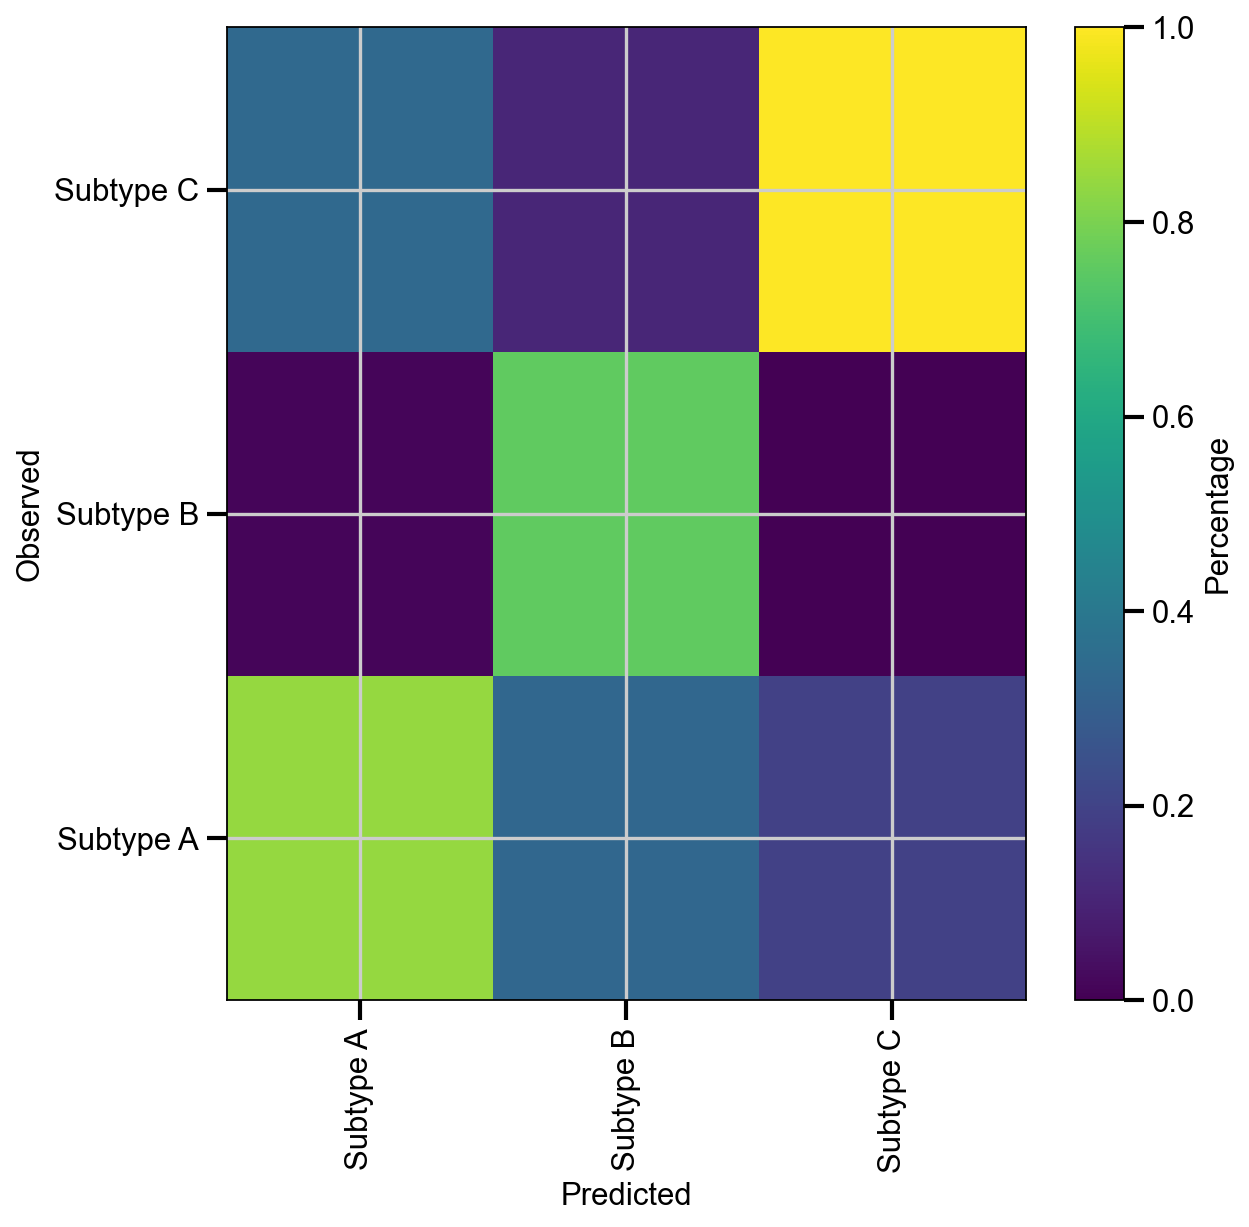

In [35]:
# setting up the scvi model
# is there a way to just import this model?
vae_152 = scvi.model.SCVI(adata_152, n_layers=2, n_latent=30, gene_likelihood="nb")


# Training the OS152 model
vae_152.train()


# saving the normalized expression values
adata_152.layers["scvi_normalized"] = vae_152.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_152.get_latent_representation()


# adding the latent variables to the adata object
adata_152.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_152, use_rep="X_scVI")
sc.tl.umap(adata_152, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_152, key_added="leiden_scVI", resolution=0.58)


# plotting the clusters
sc.pl.umap(
    adata_152,
    color=["Subtype"],
    frameon=False,
)


# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_152,
    unlabeled_category= "Unknown",
    labels_key= "Subtype",
)


# training the reference model
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)


# saving the latent representation from the reference model
adata_152.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_152, use_rep="X_scANVI")
sc.tl.leiden(adata_152)
sc.tl.umap(adata_152)


# Plotting the umap
sc.pl.umap(
    adata_152,
    color=["Subtype"],
    frameon=False,
    ncols=1,
)


dir_path_scan = "OS152_model_scanvi_full_384/"
vae_ref_scan.save(dir_path_scan, overwrite=True)


# preparing the query data
scvi.model.SCANVI.prepare_query_anndata(adata_384, dir_path_scan)


# loading the query data
vae_q = scvi.model.SCANVI.load_query_data(
    adata_384,
    dir_path_scan,
)


# Training the query model
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)


# getting the latent representation from the query model and saving it on the adata 384 dataset
adata_384.obsm["X_scANVI"] = vae_q.get_latent_representation()


# Saving the normalized expression values
adata_384.layers["scvi_normalized"] = vae_q.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_q.get_latent_representation()


# adding the latent variables to the adata object
adata_384.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_384, use_rep="X_scVI")
sc.tl.umap(adata_384, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_384, key_added="leiden_scVI", resolution=0.6)


# plotting the clusters
sc.pl.umap(
    adata_384,
    color=["Subtype"],
    frameon=False,
)

# Predicting subtype labels for OS384
adata_384.obs["predictions"] = vae_q.predict()


df = adata_384.obs.groupby(["Subtype", "predictions"]).size().unstack(fill_value=0)

df.head()


norm_df = df / df.sum(axis=0)

norm_df.head()

norm = mpl.colors.Normalize(vmin=0, vmax=1)


/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_48615/1614067739.py:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  _ = plt.colorbar(mpl.cm.ScalarMappable(norm=norm), orientation='vertical', label='Percentage')


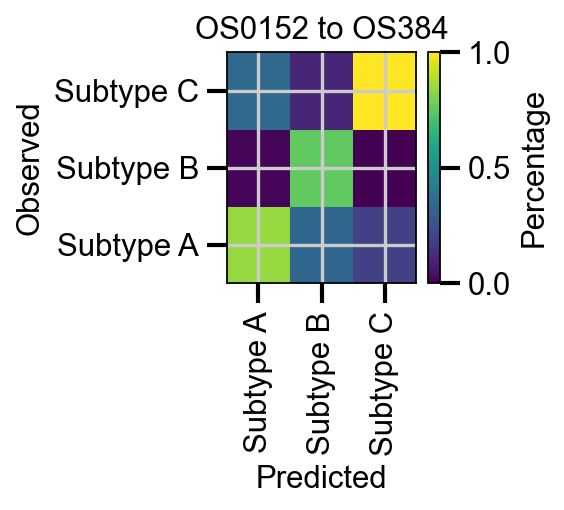

In [38]:
# Your code to generate the plot
plt.figure(figsize=(1.9, 1.9))

_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
_ = plt.colorbar(mpl.cm.ScalarMappable(norm=norm), orientation='vertical', label='Percentage')

plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("OS0152 to OS384")

# Save the plot as an SVG file
plt.savefig('/Users/brendamelano/Desktop/OS152_OS384_scANVI.svg', format='svg')

# Show the plot if needed
plt.show()

# Running simulation to test accuracy

In [24]:
adata_OS384 = adata_384

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


Accuracy: 0.684957
Precision: 0.718004
Recall: 0.684957
F1 Score: 0.668228
Confusion Matrix:
[[ 633  579  122]
 [  21 1208   11]
 [ 145  144  381]]
F1 Scores by Subtype:
Subtype A: 0.593530
Subtype B: 0.761905
Subtype C: 0.643581


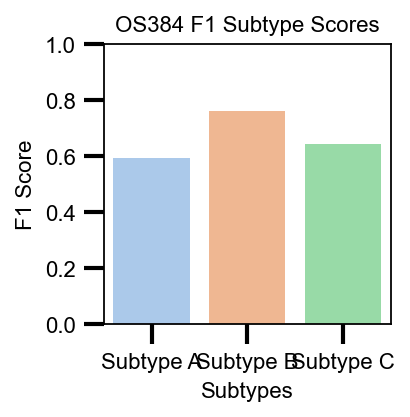

In [33]:

def evaluate_and_plot_f1_scores(adata, adata_name, true_label_key='Subtype', prediction_key='predictions', output_file='f1_scores.svg',  font_size=10):
    """
    Evaluate and plot F1 scores for different subtypes in the given AnnData object.

    Parameters:
    adata (AnnData): AnnData object containing true labels and predictions.
    adata_name (str): The name of the adata object.
    true_label_key (str): Key for the true labels in `adata.obs`.
    prediction_key (str): Key for the predicted labels in `adata.obs`.
    output_file (str): The file path to save the SVG plot.

    Returns:
    None
    """
    # Extract true and predicted labels
    true_labels = adata.obs[true_label_key]
    predicted_labels = adata.obs[prediction_key]

    # Calculate overall metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Classification report for detailed metrics per class
    class_report = classification_report(true_labels, predicted_labels, output_dict=True)

    # Extract F1 scores for each subtype
    f1_scores = {subtype: metrics['f1-score'] for subtype, metrics in class_report.items() if subtype not in ['accuracy', 'macro avg', 'weighted avg']}
    
    # Print overall metrics
    print(f"Accuracy: {accuracy:.6f}")
    print(f"Precision: {precision:.6f}")
    print(f"Recall: {recall:.6f}")
    print(f"F1 Score: {f1:.6f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print F1 scores for each subtype
    print("F1 Scores by Subtype:")
    for subtype, score in f1_scores.items():
        print(f"{subtype}: {score:.6f}")
        
    # Set the font family and size globally for the plot
    plt.rcParams['font.size'] = font_size
    plt.rcParams['axes.titlesize'] = font_size
    plt.rcParams['axes.labelsize'] = font_size
    plt.rcParams['xtick.labelsize'] = font_size
    plt.rcParams['ytick.labelsize'] = font_size
    plt.rcParams['legend.fontsize'] = font_size
    plt.rcParams['figure.titlesize'] = font_size

    # Create bar plot for F1 scores
    subtypes = list(f1_scores.keys())
    scores = list(f1_scores.values())

    # Generate plot title using the adata_name
    plot_title = f"{adata_name.replace('adata_', '').strip()} F1 Subtype Scores"

    plt.figure(figsize=(2.3, 2.3))
    sns.barplot(x=subtypes, y=scores, palette='pastel')
    plt.ylim(0, 1)
    plt.xlabel('Subtypes')
    plt.ylabel('F1 Score')
    plt.title(plot_title)

    # Remove gridlines
    plt.grid(False)

    # Save the plot as SVG
    plt.savefig(output_file, format='svg')

    # Show the plot
    plt.show()

# Example usage:
evaluate_and_plot_f1_scores(adata_384, "adata_OS384", output_file='/Users/brendamelano/Desktop/f1_scores_384.svg', font_size=10)


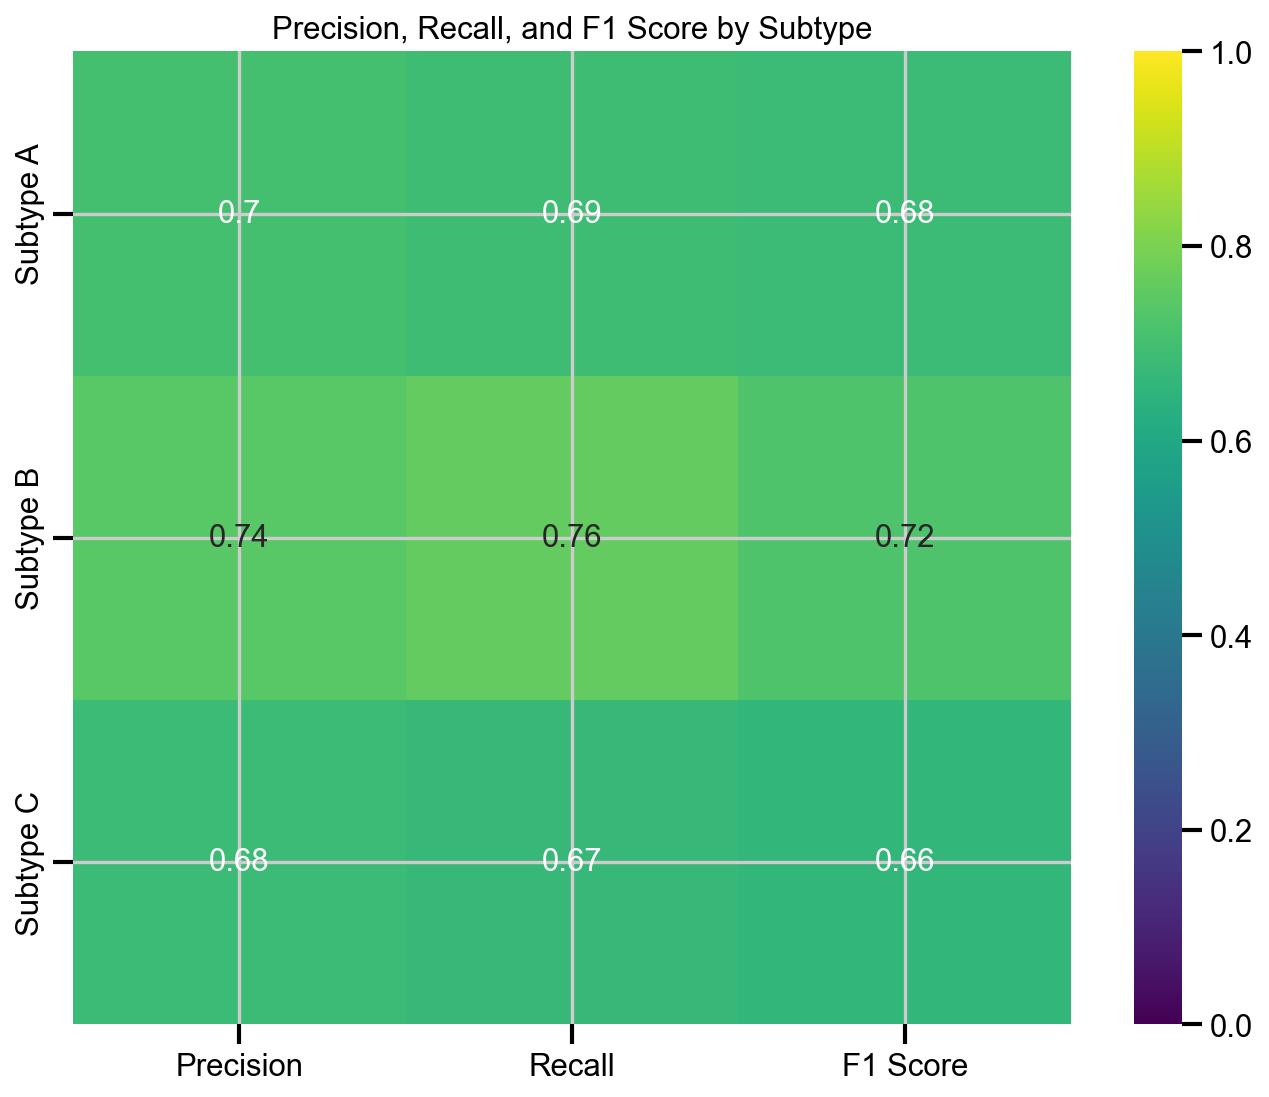

In [8]:
import pandas as pd

# Example data
data = {
    'Precision': [0.70, 0.74, 0.68],
    'Recall': [0.69, 0.76, 0.67],
    'F1 Score': [0.68, 0.72, 0.66]
}
df = pd.DataFrame(data, index=['Subtype A', 'Subtype B', 'Subtype C'])

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1)
plt.title('Precision, Recall, and F1 Score by Subtype')
plt.show()


In [15]:
import numpy as np
from sklearn.metrics import f1_score
import random

# Function to compute F1 score
def compute_f1_score(true_labels, predicted_labels):
    return f1_score(true_labels, predicted_labels, average='weighted')

# True and predicted labels from your model
true_labels = adata_384.obs["Subtype"]
predicted_labels = adata_384.obs["predictions"]

# Observed F1 score
observed_f1 = compute_f1_score(true_labels, predicted_labels)

# Number of permutations
n_permutations = 100000  # Increase the number of permutations
permuted_f1_scores = []

for _ in range(n_permutations):
    # Shuffle the true labels
    shuffled_labels = random.sample(list(true_labels), len(true_labels))
    
    # Compute the F1 score with shuffled labels
    permuted_f1 = compute_f1_score(shuffled_labels, predicted_labels)
    permuted_f1_scores.append(permuted_f1)

# Calculate p-value
p_value = np.mean([f1 >= observed_f1 for f1 in permuted_f1_scores])

# Set a minimum threshold for the p-value based on the number of permutations
min_p_value = 1 / n_permutations
p_value = max(p_value, min_p_value)

print(f'Observed F1 Score: {observed_f1:.6f}')
print(f'p-value: {p_value:.3e}')


Observed F1 Score: 0.668228
p-value: 1.000e-05


# OS384 to OS152

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|███████| 400/400 [01:59<00:00,  3.46it/s, loss=392, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [01:59<00:00,  3.36it/s, loss=392, v_num=1]
computing neighbors


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


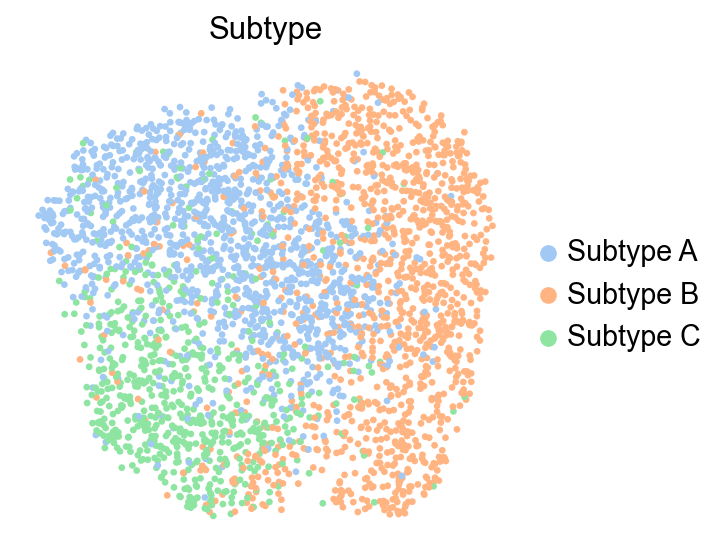

INFO     Training for 20 epochs.                                                                                   


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|███████████| 20/20 [00:11<00:00,  1.77it/s, loss=403, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████| 20/20 [00:11<00:00,  1.76it/s, loss=403, v_num=1]


In [4]:
# setting up the scvi model
# is there a way to just import this model?
vae_384 = scvi.model.SCVI(adata_384, n_layers=2, n_latent=30, gene_likelihood="nb")

vae_384.train()

# saving the normalized expression values
adata_384.layers["scvi_normalized"] = vae_384.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_384.get_latent_representation()


# adding the latent variables to the adata object
adata_384.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_384, use_rep="X_scVI")
sc.tl.umap(adata_384, min_dist=0.3)

# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_384, key_added="leiden_scVI", resolution=0.58)

# plotting the clusters
sc.pl.umap(
    adata_384,
    color=["Subtype"],
    frameon=False,
)

# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_384,
    unlabeled_category= "Unknown",
    labels_key= "Subtype",
)


# training the reference model
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


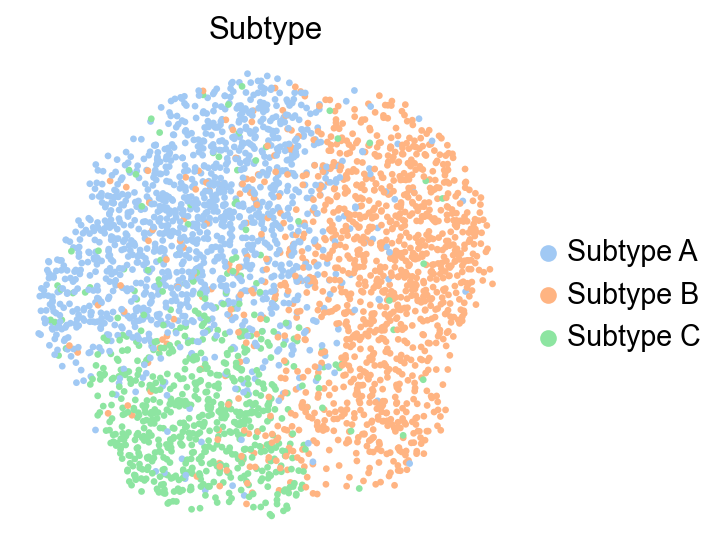

INFO     File OS384_model_scanvi_full_152/model.pt already downloaded                                              
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File OS384_model_scanvi_full_152/model.pt already downloaded                                              
INFO     Training for 100 epochs.                                                                                  


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|███████| 100/100 [01:34<00:00,  1.05it/s, loss=401, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████| 100/100 [01:34<00:00,  1.06it/s, loss=401, v_num=1]


In [5]:
# saving the latent representation from the reference model
adata_384.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_384, use_rep="X_scANVI")
sc.tl.leiden(adata_384)
sc.tl.umap(adata_384)


# plotting the umap
sc.pl.umap(
    adata_384,
    color=["Subtype"],
    frameon=False,
    ncols=1,
)


dir_path_scan = "OS384_model_scanvi_full_152/"
vae_ref_scan.save(dir_path_scan, overwrite=True)


# preparing the query data
scvi.model.SCANVI.prepare_query_anndata(adata_152, dir_path_scan)


# loading the query data
vae_q = scvi.model.SCANVI.load_query_data(
    adata_152,
    dir_path_scan,
)


# training the query model
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)


# getting the latent representation from the query model and saving it on the adata 384 dataset
adata_152.obsm["X_scANVI"] = vae_q.get_latent_representation()

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


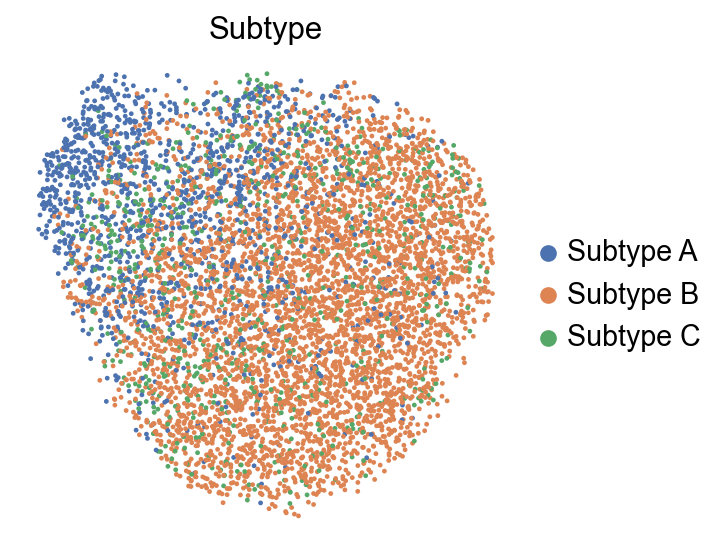

/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_48224/4005439760.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  _ = plt.colorbar(mpl.cm.ScalarMappable(norm=norm),


Text(0, 0.5, 'Observed')

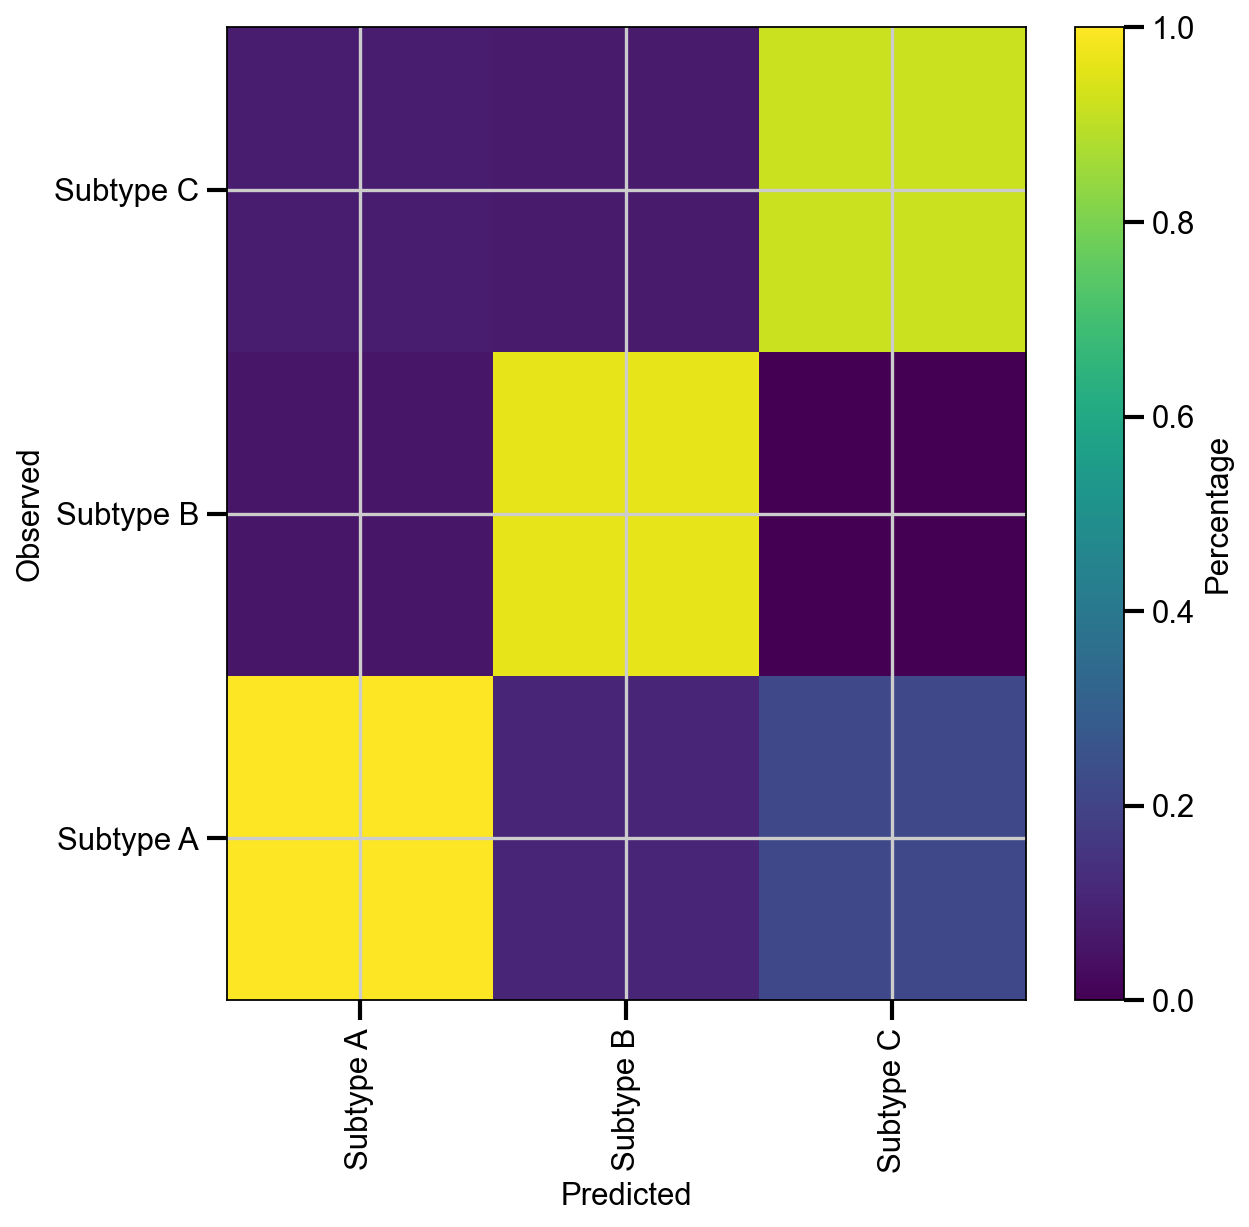

In [6]:
# saving the normalized expression values
adata_152.layers["scvi_normalized"] = vae_q.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_q.get_latent_representation()


# adding the latent variables to the adata object
adata_152.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_152, use_rep="X_scVI")
sc.tl.umap(adata_152, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_152, key_added="leiden_scVI", resolution=0.6)


# plotting the clusters
sc.pl.umap(
    adata_152,
    color=["Subtype"],
    frameon=False,
)

adata_152.obs["predictions"] = vae_q.predict()

df = adata_152.obs.groupby(["Subtype", "predictions"]).size().unstack(fill_value=0)

df.head()


norm_df = df / df.sum(axis=0)

norm_df.head()

norm = mpl.colors.Normalize(vmin=0, vmax=1)

plt.figure(figsize=(8, 8))

_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
_ = plt.colorbar(mpl.cm.ScalarMappable(norm=norm),
             orientation='vertical', label='Percentage')
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [7]:
norm_df

predictions,Subtype A,Subtype B,Subtype C
Subtype,,,
Subtype A,0.757485,0.145470,0.222222
Subtype B,0.113772,0.731665,0.074074
Subtype C,0.128743,0.122865,0.703704
